In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from astropy.io import fits
from astropy.visualization import simple_norm


hdu = fits.open('red_jo204_3D_SLres_VBIN015_total.fits.gz', memmap=True)  
nHDUs = np.size(hdu[:])
print("Number of HDUs: {}".format(nHDUs))
print("-------------")
print(hdu.info())
print("-------------")
print(hdu[0].header)
print("-------------")
data = hdu[0].data
hdu.close() # Close the FITS file - you already read it and stored it in array "data" so you don't need it anymore! In this way, you're sure it won't continue using up excess memory or file handles on your computer. (This happens automatically when you close Python, but you never know how long that might be...)
print(data.shape)

Number of HDUs: 1
-------------
Filename: red_jo204_3D_SLres_VBIN015_total.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     100   (353, 370, 72)   float32   
None
-------------
SIMPLE  =                    T / Standard FITS format: NOST 100-2.0             BITPIX  =                  -32 / No. of bits per pixel                          NAXIS   =                    3 / No. of axes in image                           NAXIS1  =                  353 / No. of pixels                                  NAXIS2  =                  370 / No. of pixels                                  NAXIS3  =                   72 / No. of pixels                                  EXTEND  =                    T / FITS extension may be present                  COMMENT NOST 100-2.0: Hanisch,R. et al. 2001, Astron. & Astrophys. 376, 559                                                                                                                                   

In [22]:
# functions

# turning arcsec to kiloparsec
def arcsec2pc(θ):
    d = 192.92*10**3 # (kpc)
    s = d * θ * np.pi/(180*60*60)
    return s # (kpc)
def pc2arcsec(θ):
    d = 192.92*10**3 # (kpc)
    s2 = d * θ / np.pi*(180*60*60)
    return s2 

print("1 arcsec = {} kpc".format( arcsec2pc(1) ))
print("20 arcsec = {} kpc".format( arcsec2pc(20) ))


def masking(array2D, a, b):   # Domain [a,b]
    array2DMask = array2D.copy()
    for i in range( len(array2D[:,0]) ):
        for j in range( len(array2D[0,:]) ):
            if array2D[i,j] < a or array2D[i,j] > b:
                array2DMask[i,j] = 0
    return array2DMask

def masking2(array2D, a, b):   # Domain [a,b]
    array2DMask = array2D.copy()
    for i in range( len(array2D[:,0]) ):
        for j in range( len(array2D[0,:]) ):
            if array2D[i,j] < a or array2D[i,j] > b:
                array2DMask[i,j] = a
            if array2D[i,j] > b:
                array2DMask[i,j] = b
    return array2DMask

def maskAbs(A): # A is a 2d array
    B = A.copy()
    for i in range( len(A[:,0]) ):
        for j in range( len(A[0,:]) ):
            B[i,j] = abs(A[i,j])
    return B

def maskSig(A,sigmaA, sigma_a, sigma_b): # A is a 2d array
    B = A.copy()
    for i in range( len(A[:,0]) ):
        for j in range( len(A[0,:]) ):
            #remove noise
            if sigmaA[i,j] < sigma_a or sigmaA[i,j] > sigma_b:
                B[i,j] = -99
    return B

# turning nº of points into arcsec
x0 = -32.8
xf = 353 *0.2 - 32.8
y0 = - 370 *0.2 + 39.2
yf = 39.2

1 arcsec = 0.9353025535965169 kpc
20 arcsec = 18.706051071930336 kpc


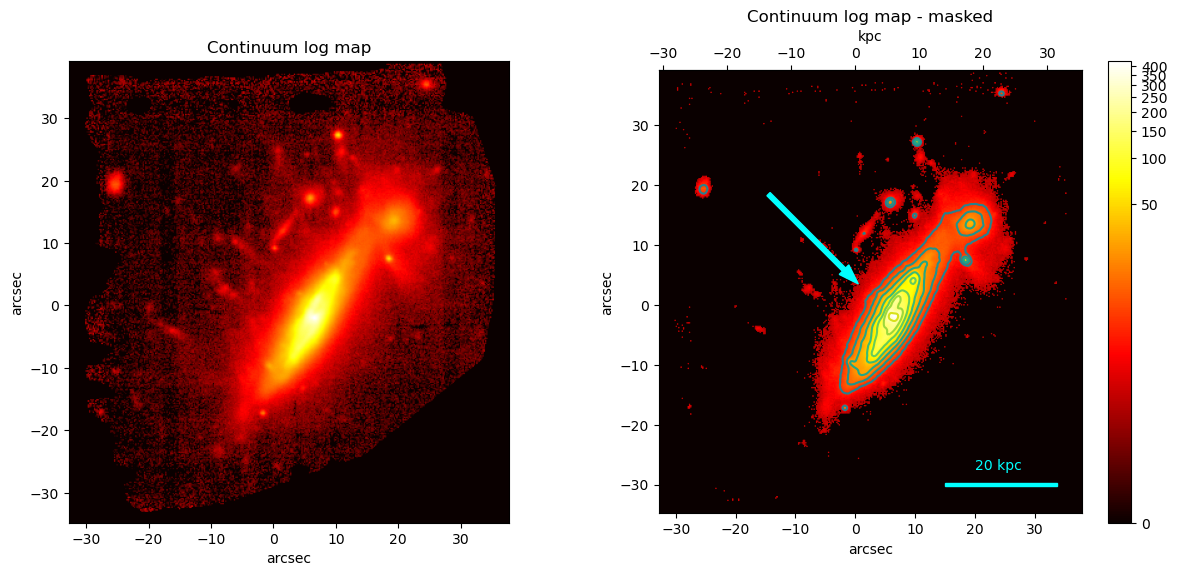

In [23]:
# plot continuum contour map
conti = data[0,:,:]

# turning nº of points into arcsec
x0 = -32.8
xf = len(conti[0,:])*0.2 - 32.8
y0 = -len(conti[:,0])*0.2 + 39.2
yf = 39.2
#print(x0,xf,y0,yf)


# values of continuum into logscale
normC = simple_norm(conti,"log")

# ploting data
fig,axs = plt.subplots(1,2,figsize=(15,6))
im = axs[0].imshow(conti,norm = normC, origin='lower', cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(im, label="")
axs[0].set_title("Continuum log map")
axs[0].set_xlabel("arcsec")
axs[0].set_ylabel("arcsec")

#makes the data smoother
from scipy.ndimage.filters import gaussian_filter
smoothConti = gaussian_filter(conti, sigma=.75)
contourVals = np.logspace(3,9,num=8,base = 2)
#print("Values for the levels of the Contour map\n",contourVals)


contiMask = masking(conti,2,500)
normaCM = simple_norm(contiMask,"log")

imCM = axs[1].imshow(contiMask,norm = normaCM, origin='lower', cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
#plt.colorbar(imCM, label="$\Delta$ v (km/s)");
axs[1].contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
axs[1].set_title("Continuum log map - masked")
axs[1].set_xlabel("arcsec")
axs[1].set_ylabel("arcsec")
axs[1].arrow(15,-30,18.706,0, width=0.5,head_width=0,color="aqua")
axs[1].text(20, -27.5, '20 kpc', fontsize=10,color="aqua")
# axs[1].arrow(-2,-14,16,23, width=0.5,head_width=0,color="green")
# axs[1].arrow(-10,-10,16,23, width=0.5,head_width=0,color="green")
# axs[1].arrow(-18,-6,16,23, width=0.5,head_width=0,color="green")
# axs[1].arrow(-26,-2,16,23, width=0.5,head_width=0,color="green")
axs[1].arrow(-20+5.5,20-1.5,15,-15, width=0.75, length_includes_head = True, color="aqua")
secax = axs[1].secondary_xaxis('top', functions=(arcsec2pc,pc2arcsec))
secax.set_xlabel("kpc")
plt.show()

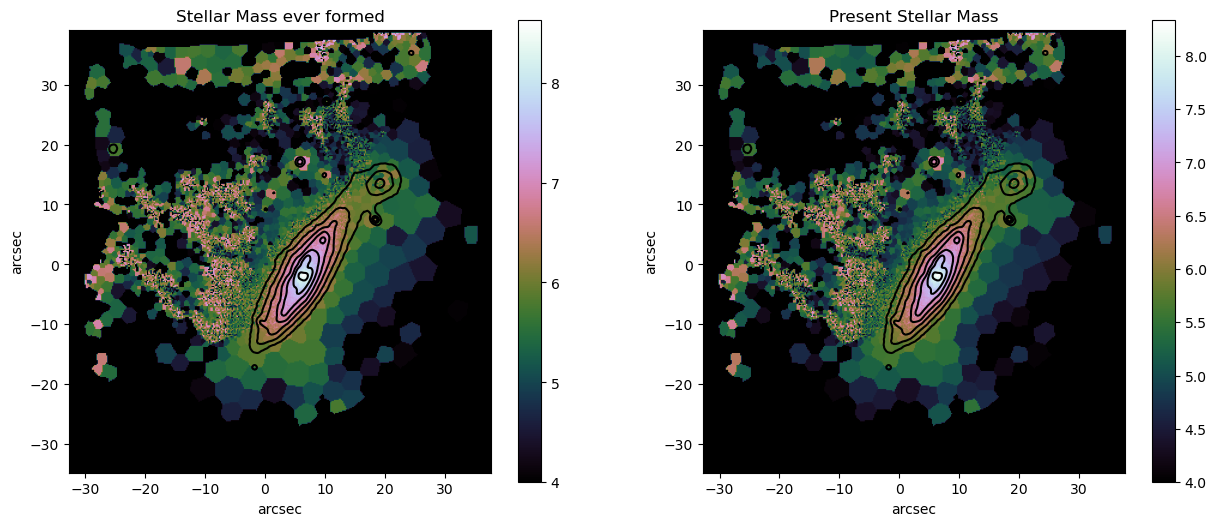

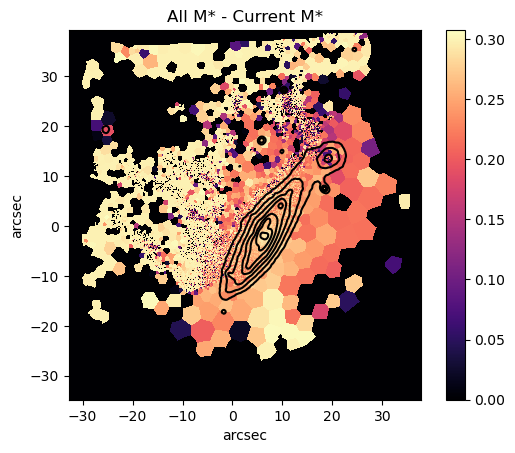

In [24]:
allM = data[27,:,:] 
allM_mask= masking2(allM,4,100)
norma = simple_norm(allM_mask)

plt.subplots(1,2,figsize=(15,6))
plt.subplot(1,2,1)
im = plt.imshow(allM_mask, origin='lower',norm=norma, cmap=plt.get_cmap("cubehelix"), extent=[x0,xf,y0,yf])
plt.colorbar(im);
plt.contour(smoothConti, norm=normC, levels=contourVals,colors="k", origin='lower', extent=[x0,xf,y0,yf])
plt.title("Stellar Mass ever formed")
plt.xlabel("arcsec")
plt.ylabel("arcsec")


currentM = data[28,:,:] 
currentM_mask= masking2(currentM,4,100)
plt.subplot(1,2,2)
im = plt.imshow(currentM_mask, origin='lower', cmap=plt.get_cmap("cubehelix"), extent=[x0,xf,y0,yf])
plt.colorbar(im);
plt.contour(smoothConti, norm=normC, levels=contourVals,colors="k", origin='lower', extent=[x0,xf,y0,yf])
plt.title("Present Stellar Mass")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.show()


im = plt.imshow(allM_mask - currentM_mask, origin='lower', cmap=plt.get_cmap("magma"), extent=[x0,xf,y0,yf])
plt.colorbar(im);
plt.contour(smoothConti, norm=normC, levels=contourVals,colors="k", origin='lower', extent=[x0,xf,y0,yf])
plt.title("All M* - Current M*")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.show()

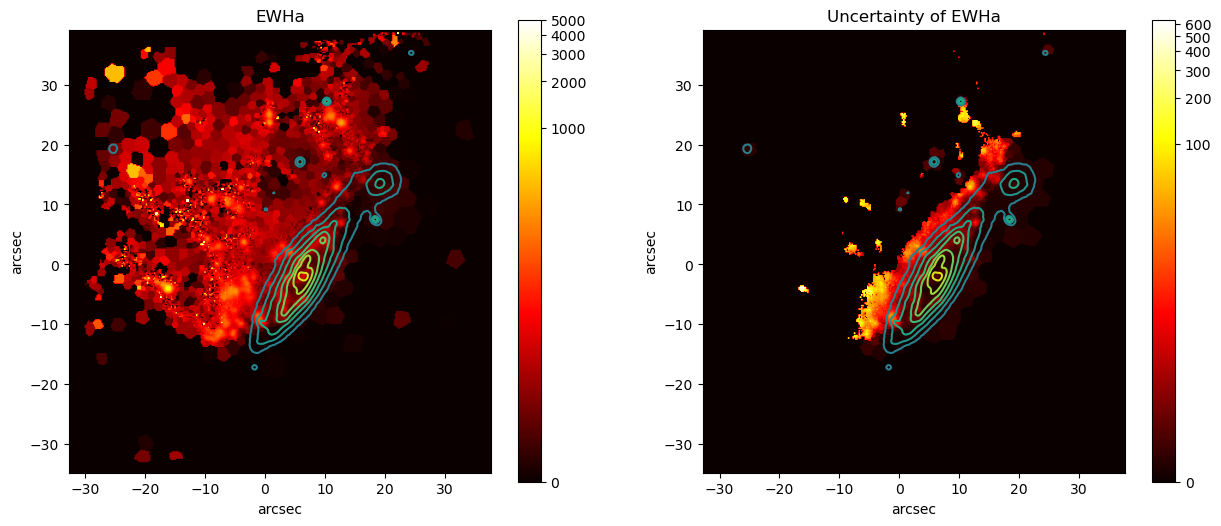

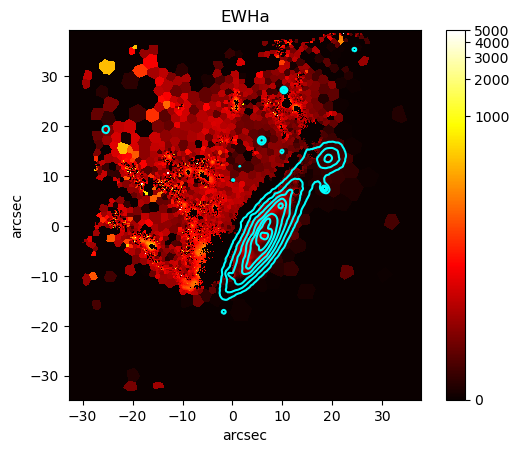

In [25]:
EWHa = masking2(data[51,:,:],0,5000)
norma = simple_norm(EWHa,"log")
plt.subplots(1,2,figsize=(15,6))
plt.subplot(1,2,1)
im = plt.imshow(EWHa, origin='lower',norm=norma, cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(im);
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("EWHa")
plt.xlabel("arcsec")
plt.ylabel("arcsec")

 
EWHa_unc= masking2(data[52,:,:],0,10**4)
norma = simple_norm(EWHa_unc,"log")
plt.subplot(1,2,2)
im = plt.imshow(EWHa_unc, origin='lower', norm=norma,cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(im);
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("Uncertainty of EWHa")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.show()

EWHa_mask = maskSig(EWHa,EWHa_unc, -0.01,3)
EWHa_mask2 = masking(EWHa_mask, 0,10000)
norma = simple_norm(EWHa_mask2,"log")
im = plt.imshow(EWHa_mask2, origin='lower',norm=norma, cmap=plt.get_cmap("hot"), extent=[x0,xf,y0,yf])
plt.colorbar(im)
plt.contour(smoothConti, norm=normC, levels=contourVals,colors="aqua", origin='lower', extent=[x0,xf,y0,yf])
plt.title("EWHa")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.show()

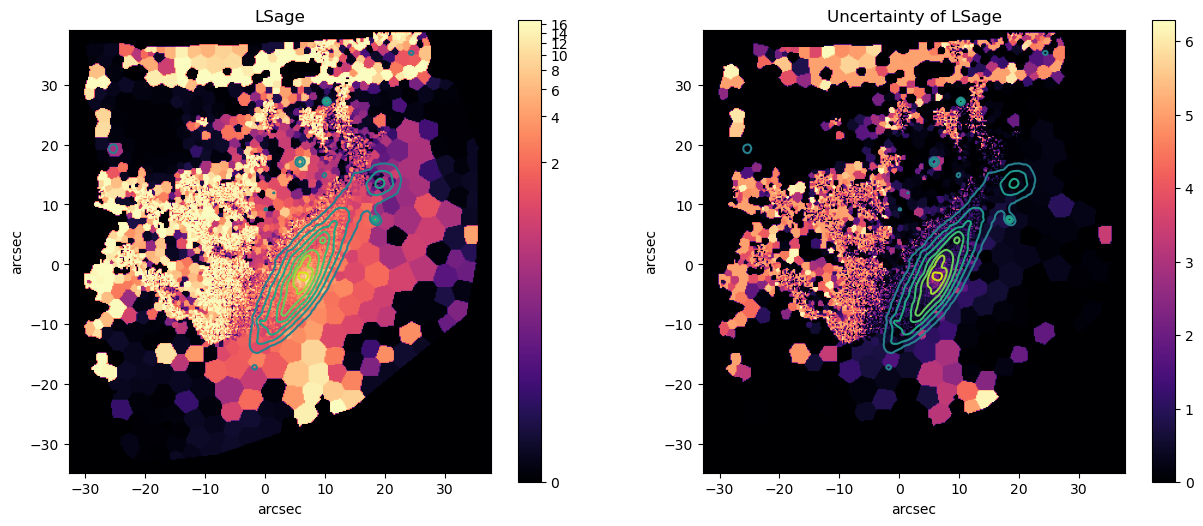

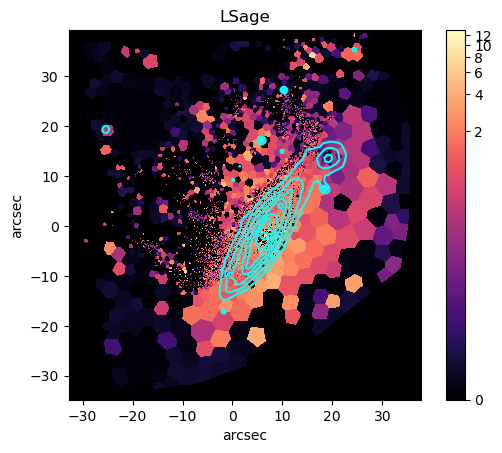

In [26]:
LSage = masking2(data[7,:,:],0,10**5)
norma = simple_norm(LSage,"log")
plt.subplots(1,2,figsize=(15,6))
plt.subplot(1,2,1)
im = plt.imshow(LSage, origin='lower',norm=norma, cmap=plt.get_cmap("magma"), extent=[x0,xf,y0,yf])
plt.colorbar(im);
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("LSage")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
 
LSage_unc= masking2(data[8,:,:],-10,10)
norma = simple_norm(LSage_unc)
plt.subplot(1,2,2)
im = plt.imshow(LSage_unc, origin='lower', norm=norma,cmap=plt.get_cmap("magma"), extent=[x0,xf,y0,yf])
plt.colorbar(im);
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("Uncertainty of LSage")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.show()

LSage_mask = maskSig(LSage,LSage_unc, -0.01,2)
LSage_mask2 = masking(LSage_mask,-10,100)
norma = simple_norm(LSage_mask2,"log")
im = plt.imshow(LSage_mask2, origin='lower',norm=norma, cmap=plt.get_cmap("magma"), extent=[x0,xf,y0,yf])
plt.colorbar(im);
plt.contour(smoothConti, norm=normC, levels=contourVals,colors="aqua", origin='lower', extent=[x0,xf,y0,yf])
plt.title("LSage")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.show()

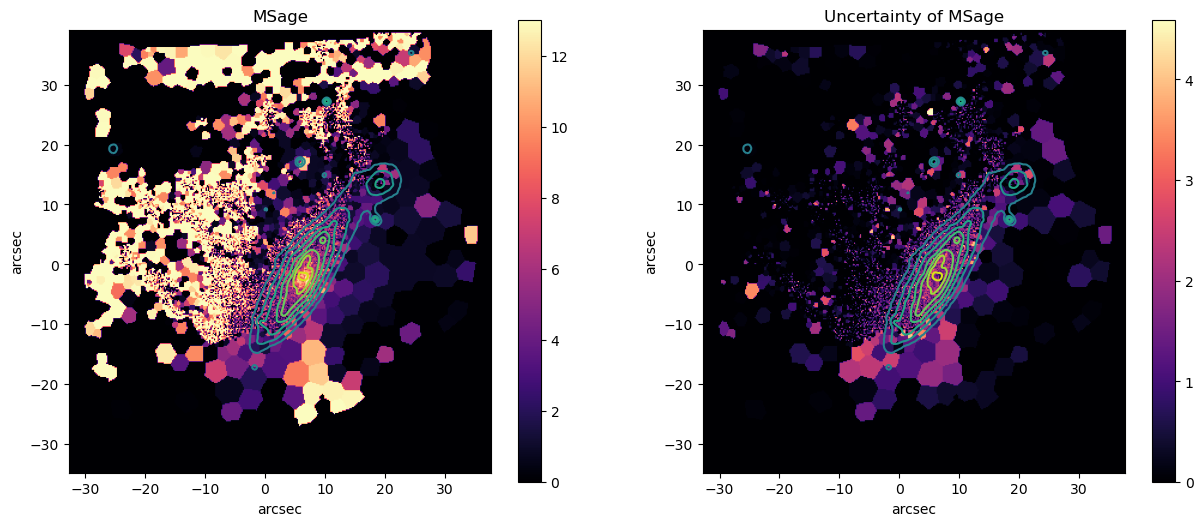

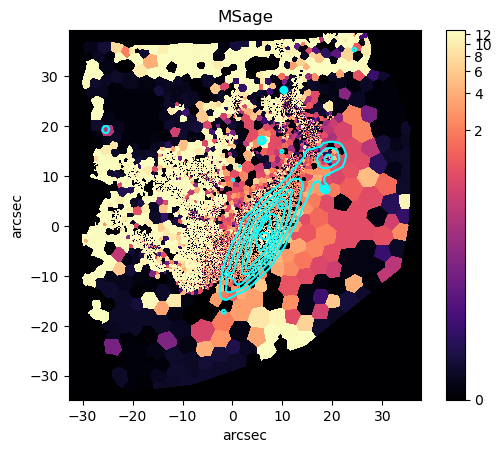

In [27]:
MSage = masking2(data[9,:,:],0,10**5)
norma = simple_norm(MSage)
plt.subplots(1,2,figsize=(15,6))
plt.subplot(1,2,1)
im = plt.imshow(MSage, origin='lower',norm=norma, cmap=plt.get_cmap("magma"), extent=[x0,xf,y0,yf])
plt.colorbar(im);
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("MSage")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
 
MSage_unc= masking2(data[10,:,:],0,10**5)
norma = simple_norm(MSage_unc)
plt.subplot(1,2,2)
im = plt.imshow(MSage_unc, origin='lower', norm=norma,cmap=plt.get_cmap("magma"), extent=[x0,xf,y0,yf])
plt.colorbar(im);
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower', extent=[x0,xf,y0,yf])
plt.title("Uncertainty of MSage")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.show()

MSage_mask = maskSig(MSage,MSage_unc, -0.01,2)
MSage_mask2 = masking(MSage_mask,-10,100)
norma = simple_norm(MSage_mask2,"log")
im = plt.imshow(MSage_mask2, origin='lower',norm=norma, cmap=plt.get_cmap("magma"), extent=[x0,xf,y0,yf])
plt.colorbar(im);
plt.contour(smoothConti, norm=normC, levels=contourVals,colors="aqua", origin='lower', extent=[x0,xf,y0,yf])
plt.title("MSage")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.show()

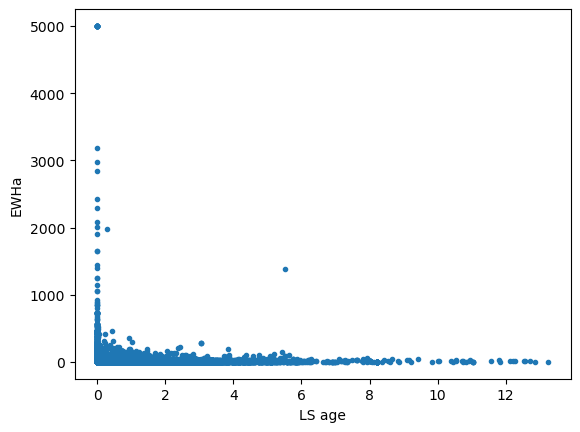

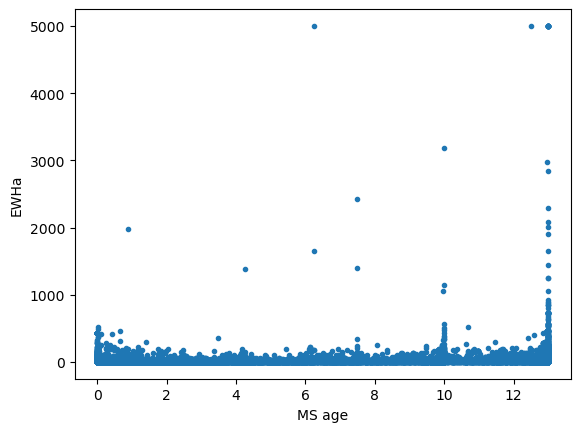

In [28]:
Nvals = 370 * 353
x_LSage = np.zeros(Nvals)
x_MSage = np.zeros(Nvals)
y_EWHa = np.zeros(Nvals)

c = 0
for i in range(370):
    for j in range(353):
        
        x_LSage[c] = LSage_mask2[i,j]
        x_MSage[c] = MSage_mask2[i,j]
        y_EWHa[c]  = EWHa_mask2[i,j]
        
        c += 1 

plt.plot(x_LSage, y_EWHa,".")
plt.xlabel("LS age")
plt.ylabel("EWHa")
#plt.xscale("log")
#plt.yscale("log")
# plt.xlim(-1,18)
# plt.ylim(-1,125)
plt.show()

plt.plot(x_MSage, y_EWHa,".")
plt.xlabel("MS age")
plt.ylabel("EWHa")
#plt.xscale("log")
#plt.yscale("log")
# plt.xlim(-1,18)
# plt.ylim(-1,125)

plt.show()

O centro da galáxia é quando l = 15.053176575062153


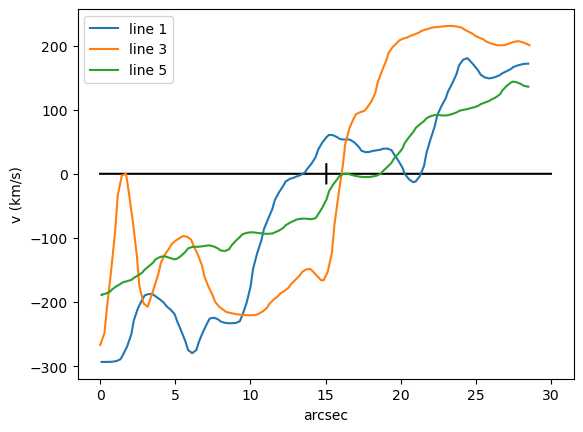

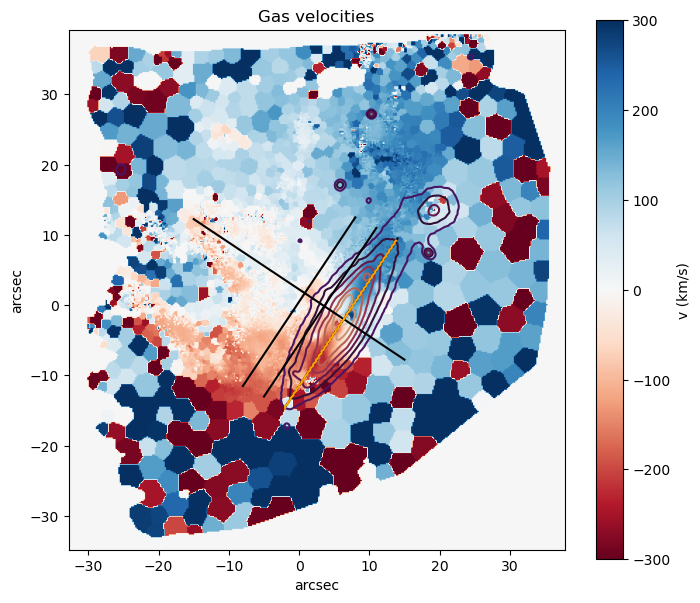

In [29]:
vGas = data[71,:,:] # mean v of strongest lines
vGasMask = masking2(vGas,-300,300)

def f1(x):
    return 1.5*x - 11.5
def f2(x):
    return 1.5*x - 8.5
def f3(x):
    return 1.5*x - 5.5
def f4(x):
    return 1.5*x - 2.5
def f5(x):
    return 1.5*x + 0.5

xs1 = np.linspace(-2,14,10**4)
ys1 = f1(xs1)
xs2 = np.linspace(-3.5,12.5,10**4)
ys2 = f2(xs2)
xs3 = np.linspace(-5,11,10**4)
ys3 = f3(xs3)
xs4 = np.linspace(-6.5,9.5,10**4)
ys4 = f4(xs4)
xs5 = np.linspace(-8,8,10**4)
ys5 = f5(xs5)


# Pt interseção ylinha1 com centro galáxia
xC = 6.35
yC = f1(6.35)

# reta perpendicular que passa no centro
def fC(x):
    bC = yC + 1/1.5*xC
    return -1/1.5*x + bC

xN = xC +2
yN = yC - f1(-2)
tet = np.arctan(yN/xN)
lVal = xN/np.cos(tet)
print("O centro da galáxia é quando l =",lVal)

linha1 = np.array([])
xlinha1 = np.array([])
linha2 = np.array([])
xlinha2 = np.array([])
linha3 = np.array([])
xlinha3 = np.array([])
linha4 = np.array([])
xlinha4 = np.array([])
linha5 = np.array([])
xlinha5 = np.array([])
linha6 = np.array([])

y1 = np.array([])

l1 = np.array([])
l2 = np.array([])
l3 = np.array([])
l4 = np.array([])
l5 = np.array([])


incerteza = 0.15
for i in range(353):
    for j in range(370):
        yVal = i *0.2 - 32.8
        xVal = - 370*0.2 + j*0.2 + 39.2
        
        if yVal-incerteza<= f1(xVal) <= yVal+incerteza and -2<=xVal<=14:
            linha1 = np.append(linha1, vGasMask[i,j])
            xlinha1 = np.append(xlinha1, xVal)
            y1 = np.append(y1, yVal)
            xNovo = xVal +2
            yNovo = yVal - f1(-2)
            teta = np.arctan(yNovo/xNovo)
            l1 = np.append(l1, xNovo/np.cos(teta))
        if yVal-incerteza<= f2(xVal) <= yVal+incerteza and -3.5<=xVal<=12.5:
            linha2 = np.append(linha2, vGasMask[i,j])
            xlinha2 = np.append(xlinha2, xVal)
            xNovo = xVal +3.51
            yNovo = yVal - f2(-3.5)
            teta = np.arctan(yNovo/xNovo)
            l2 = np.append(l2, xNovo/np.cos(teta))
        if yVal-incerteza<= f3(xVal) <= yVal+incerteza and -5<=xVal<=11:
            linha3 = np.append(linha3, vGasMask[i,j])
            xlinha3 = np.append(xlinha3, xVal)
            xNovo = xVal +5.01
            yNovo = yVal - f3(-5)
            teta = np.arctan(yNovo/xNovo)
            l3 = np.append(l3, xNovo/np.cos(teta))
        if yVal-incerteza<= f4(xVal) <= yVal+incerteza and -6.5<=xVal<=9.5:
            linha4 = np.append(linha4, vGasMask[i,j])
            xlinha4 = np.append(xlinha4, xVal)
            xNovo = xVal +6.51
            yNovo = yVal - f4(-6.5)
            teta = np.arctan(yNovo/xNovo)
            l4 = np.append(l4, xNovo/np.cos(teta))
        if yVal-incerteza<= f5(xVal) <= yVal+incerteza and -8<=xVal<=8:
            linha5 = np.append(linha5, vGasMask[i,j])
            xlinha5 = np.append(xlinha5, xVal)
            xNovo = xVal +8.01
            yNovo = yVal - f5(-8)
            teta = np.arctan(yNovo/xNovo)
            l5 = np.append(l5, xNovo/np.cos(teta))

sigma = 2
ylinha1 = sc.ndimage.filters.gaussian_filter1d(linha1,sigma)
ylinha2 = sc.ndimage.filters.gaussian_filter1d(linha2,sigma)
ylinha3 = sc.ndimage.filters.gaussian_filter1d(linha3,sigma)
ylinha4 = sc.ndimage.filters.gaussian_filter1d(linha4,sigma)
ylinha5 = sc.ndimage.filters.gaussian_filter1d(linha5,sigma)


# Represent data
plt.plot(np.ones(10**4)*lVal,np.linspace(-15,15,10**4),color="k")
plt.plot(np.linspace(0,30,10**4),np.zeros(10**4),color="k")
plt.plot(l1,ylinha1,label=("line 1"))
#plt.plot(l2,ylinha2,".",label=("line 2"))
plt.plot(l3,ylinha3,label=("line 3"))
#plt.plot(l4,ylinha4,label=("line 4"))
plt.plot(l5,ylinha5,label=("line 5"))
plt.legend()
plt.xlabel("arcsec")
plt.ylabel("v (km/s)")
plt.show()

plt.figure(figsize=(8,7))
im3 = plt.imshow(vGasMask, origin='lower', cmap=plt.get_cmap("RdBu"), extent=[x0,xf,y0,yf])
plt.colorbar(im3, label="v (km/s)");
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower',cmap=plt.get_cmap("twilight"), extent=[x0,xf,y0,yf])
plt.plot(np.linspace(-15,15,10**4),fC(np.linspace(-15,15,10**4)),color="k")
plt.plot(xs1,ys1,color="k",label=("line 1"))
#plt.plot(xs2,ys2,color="k",label=("line 2"))
plt.plot(xs3,ys3,color="k",label=("line 3"))
#plt.plot(xs4,ys4,color="k",label=("line 4"))
plt.plot(xs5,ys5,color="k",label=("line 5"))
# # testar que tamos a tirar os pontos do sitio certo
plt.plot(xlinha1,y1,color="orange")

plt.title("Gas velocities")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.show()

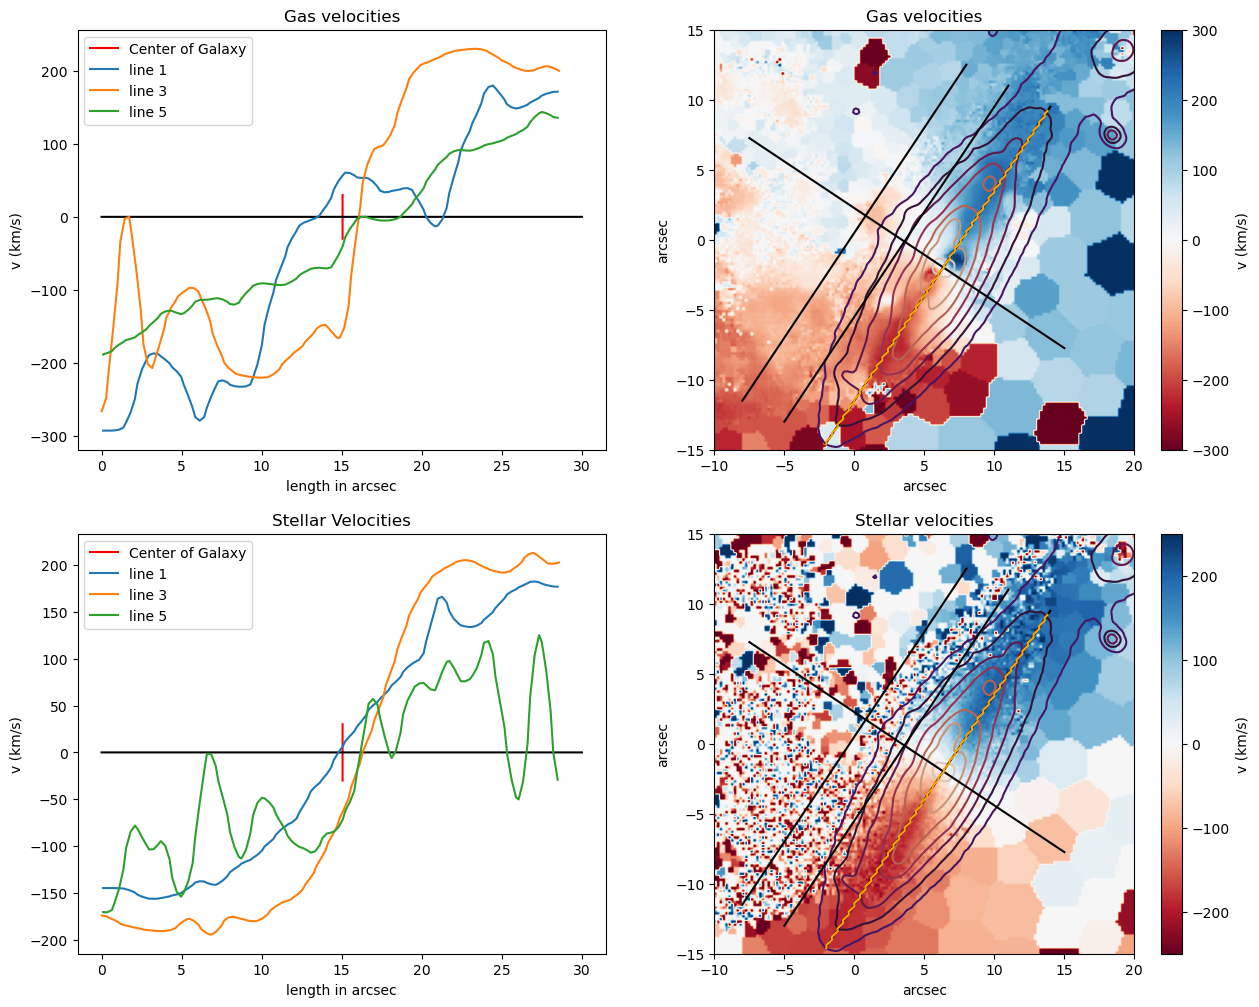

In [36]:
# Stellar velocities
Vel = data[5,:,:] 
VMask2 = masking2(Vel,-250,250)

linha1_S = np.array([])
xlinha1_S = np.array([])
linha2_S = np.array([])
xlinha2_S = np.array([])
linha3_S = np.array([])
xlinha3_S = np.array([])
linha4_S= np.array([])
xlinha4_S = np.array([])
linha5_S= np.array([])
xlinha5_S = np.array([])

y1_S = np.array([])

l1_S = np.array([])
l2_S = np.array([])
l3_S = np.array([])
l4_S = np.array([])
l5_S = np.array([])


incerteza = 0.15
for i in range(353):
    for j in range(370):
        yVal = i *0.2 - 32.8
        xVal = - 370*0.2 + j*0.2 + 39.2
        
        if yVal-incerteza<= f1(xVal) <= yVal+incerteza and -2<=xVal<=14:
            linha1_S = np.append(linha1_S, VMask2[i,j])
            xlinha1_S = np.append(xlinha1_S, xVal)
            y1_S = np.append(y1_S, yVal)
            xNovo = xVal +2
            yNovo = yVal - f1(-2)
            teta = np.arctan(yNovo/xNovo)
            l1_S = np.append(l1_S, xNovo/np.cos(teta))
        if yVal-incerteza<= f2(xVal) <= yVal+incerteza and -3.5<=xVal<=12.5:
            linha2_S = np.append(linha2_S, VMask2[i,j])
            xlinha2_S = np.append(xlinha2_S, xVal)
            xNovo = xVal +3.51
            yNovo = yVal - f2(-3.5)
            teta = np.arctan(yNovo/xNovo)
            l2_S = np.append(l2_S, xNovo/np.cos(teta))
        if yVal-incerteza<= f3(xVal) <= yVal+incerteza and -5<=xVal<=11:
            linha3_S = np.append(linha3_S, VMask2[i,j])
            xlinha3_S = np.append(xlinha3_S, xVal)
            xNovo = xVal +5.01
            yNovo = yVal - f3(-5)
            teta = np.arctan(yNovo/xNovo)
            l3_S = np.append(l3_S, xNovo/np.cos(teta))
        if yVal-incerteza<= f4(xVal) <= yVal+incerteza and -6.5<=xVal<=9.5:
            linha4_S = np.append(linha4_S, VMask2[i,j])
            xlinha4_S = np.append(xlinha4_S, xVal)
        if yVal-incerteza<= f5(xVal) <= yVal+incerteza and -8<=xVal<=8:
            linha5_S = np.append(linha5_S, VMask2[i,j])
            xlinha5_S = np.append(xlinha5_S, xVal)
            xNovo = xVal +8.01
            yNovo = yVal - f5(-8)
            teta = np.arctan(yNovo/xNovo)
            l5_S = np.append(l5_S, xNovo/np.cos(teta))
            

ylinha1_S = sc.ndimage.filters.gaussian_filter1d(linha1_S,sigma)
ylinha2_S = sc.ndimage.filters.gaussian_filter1d(linha2_S,sigma)
ylinha3_S = sc.ndimage.filters.gaussian_filter1d(linha3_S,sigma)
ylinha4_S = sc.ndimage.filters.gaussian_filter1d(linha4_S,sigma)
ylinha5_S = sc.ndimage.filters.gaussian_filter1d(linha5_S,sigma)



# plt.subplots(1,2,figsize=(15,6))
# plt.subplot(1,2,1)
plt.subplots(2,2,figsize=(15,12))
plt.subplot(2,2,1)
plt.plot(np.ones(10**4)*lVal,np.linspace(-30,30,10**4),color="red",label="Center of Galaxy")
plt.plot(np.linspace(0,30,10**4),np.zeros(10**4),color="k")
plt.plot(l1,ylinha1,label=("line 1"))
#plt.plot(l2,ylinha2,label=("line 2"))
plt.plot(l3,ylinha3,label=("line 3"))
#plt.plot(l4,ylinha4,label=("line 4"))
plt.plot(l5,ylinha5,label=("line 5"))
plt.legend()
plt.xlabel("length in arcsec")
plt.ylabel("v (km/s)")
plt.title("Gas velocities")

plt.subplot(2,2,3)
plt.plot(np.ones(10**4)*lVal,np.linspace(-30,30,10**4),color="red",label="Center of Galaxy")
plt.plot(np.linspace(0,30,10**4),np.zeros(10**4),color="k")
plt.plot(l1_S,ylinha1_S,label=("line 1"))
#plt.plot(l2_S,ylinha2_S,label=("line 2"))
plt.plot(l3_S,ylinha3_S,label=("line 3"))
plt.plot(l5_S,ylinha5_S,label=("line 5"))
plt.legend()
plt.xlabel("length in arcsec")
plt.ylabel("v (km/s)")
plt.title("Stellar Velocities")
#plt.show()


# plt.subplots(1,2,figsize=(15,6))
# plt.subplot(1,2,1)
plt.subplot(2,2,2)
imS = plt.imshow(vGasMask, origin='lower', cmap=plt.get_cmap("RdBu"), extent=[x0,xf,y0,yf])
plt.colorbar(imS, label="v (km/s)");
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower',cmap=plt.get_cmap("twilight"), extent=[x0,xf,y0,yf])
plt.plot(np.linspace(-7.5,15,10**4),fC(np.linspace(-7.5,15,10**4)),color="k")
plt.plot(xs1,ys1,color="k")
#plt.plot(xs2,ys2,color="k")
plt.plot(xs3,ys3,color="k")
# plt.plot(xs4,ys4,color="k")
plt.plot(xs5,ys5,color="k")
plt.plot(xlinha1_S,y1_S,color="orange")
plt.xlim(-10,20)
plt.ylim(-15,15)
plt.title("Gas velocities")
plt.xlabel("arcsec")
plt.ylabel("arcsec")

# plt.subplot(1,2,2)
plt.subplot(2,2,4)
imS = plt.imshow(VMask2, origin='lower', cmap=plt.get_cmap("RdBu"), extent=[x0,xf,y0,yf])
plt.colorbar(imS, label="v (km/s)");
plt.contour(smoothConti, norm=normC, levels=contourVals, origin='lower',cmap=plt.get_cmap("twilight"), extent=[x0,xf,y0,yf])
plt.plot(np.linspace(-7.5,15,10**4),fC(np.linspace(-7.5,15,10**4)),color="k")
plt.plot(xs1,ys1,color="k")
#plt.plot(xs2,ys2,color="k")
plt.plot(xs3,ys3,color="k")
# plt.plot(xs4,ys4,color="k")
plt.plot(xs5,ys5,color="k")
plt.plot(xlinha1_S,y1_S,color="orange")
plt.xlim(-10,20)
plt.ylim(-15,15)
plt.title("Stellar velocities")
plt.xlabel("arcsec")
plt.ylabel("arcsec")
plt.savefig("v dist eixo.png")
plt.show()

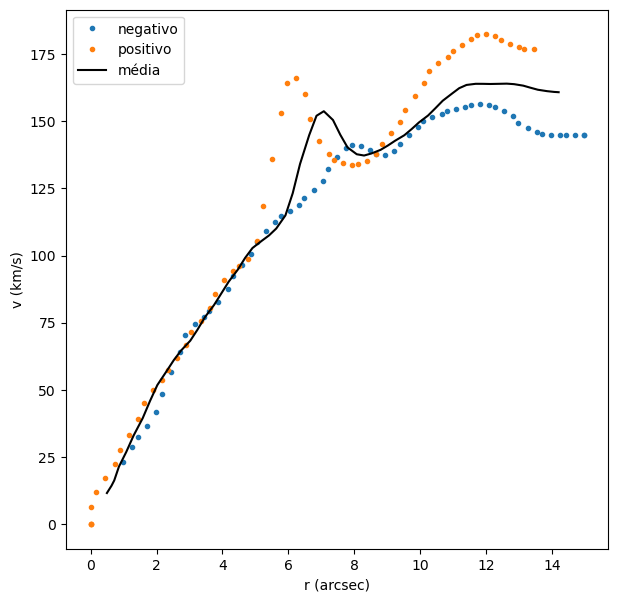

In [31]:
# Usar valore de li_S , ylinha1_S

Comp = int(len(ylinha1_S)/2)
x_vStar1 = np.zeros(Comp)
y_vStar1 = np.zeros(Comp)
x_vStar2 = np.zeros(Comp)
y_vStar2 = np.zeros(Comp)

for i in range(Comp):
    if ylinha1_S[i] <= 0:
        y_vStar1[i] = abs(ylinha1_S[i])
        x_vStar1[i] = lVal - l1_S[i] 
    if ylinha1_S[Comp + i] >= 0:
        y_vStar2[i] = ylinha1_S[Comp + i]
        x_vStar2[i] = l1_S[Comp + i] - lVal 

x_vStarMed = np.zeros(Comp)
y_vStarMed = np.zeros(Comp)
for i in range(Comp):
    y_vStarMed[i] = (y_vStar1[i] + y_vStar2[-i-1])/2
    x_vStarMed[i] = (x_vStar1[i] + x_vStar2[-i-1])/2
    #print(x_vStar1,x_vStar2)


plt.figure(figsize=(7,7))
plt.plot(x_vStar1,y_vStar1,".",label="negativo")
plt.plot(x_vStar2,y_vStar2,".",label="positivo")
plt.plot(x_vStarMed,y_vStarMed,color="k",label="média")
plt.legend()
plt.xlabel("r (arcsec)")
plt.ylabel("v (km/s)")
plt.savefig("v(r) estrelas.png")
plt.show()

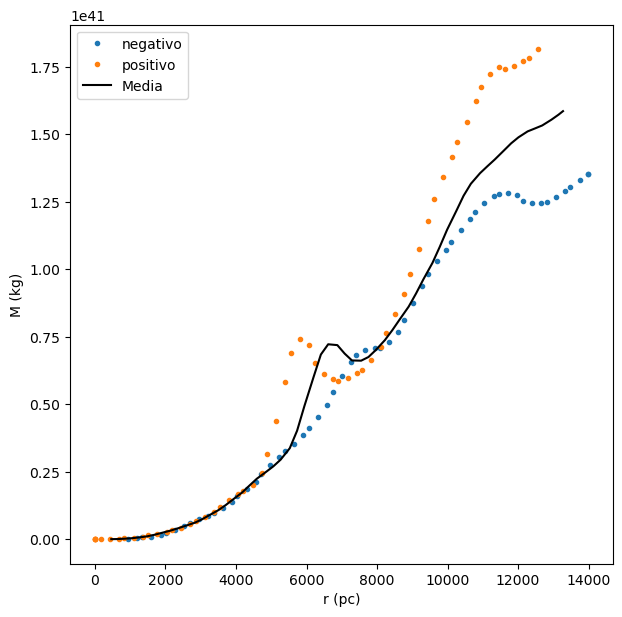

In [32]:
G = 6.674184 * 10 ** -11
ua = 1.495978707 * 10 ** 11         # m
pc = 206264.8 * ua                  # m
Mdina1 = np.zeros(Comp)
Mdina2 = np.zeros(Comp)
MdinaMed = np.zeros(Comp)
for i in range(Comp):  
    # Passar para SI
    Mdina1[i]   = (y_vStar1[i]*10**3 )**2   * arcsec2pc(x_vStar1[i])*10**3   * pc / G
    Mdina2[i]   = (y_vStar2[i]*10**3 )**2   * arcsec2pc(x_vStar2[i])*10**3   * pc / G
    MdinaMed[i] = (y_vStarMed[i]*10**3 )**2 * arcsec2pc(x_vStarMed[i])*10**3 * pc / G

plt.figure(figsize=(7,7))
plt.plot(arcsec2pc(x_vStar1)*10**3,  Mdina1,".",label="negativo")
plt.plot(arcsec2pc(x_vStar2)*10**3,  Mdina2,".",label="positivo")
plt.plot(arcsec2pc(x_vStarMed)*10**3,MdinaMed,color="k",label="Media")
plt.legend()
plt.xlabel("r (pc)")
plt.ylabel("M (kg)")
plt.savefig("M estrelas.png")
plt.show()